Grouped Bar Charts
==================
This notebook introduces the methods of creating bar charts from our data, including some of the key concepts of our plotting package, `matplotlib`. Bar charts are useful for making comparisons between close data because we are very good at evaluating the size of rectangles.

Topics covered:

- bar charts
- styling charts (titles, labels, size, color, etc)
- grouped bar charts
- new `school_data` package for custom code


In [1]:
import matplotlib.pyplot as plt
from nycschools import schools, ui, exams

df = schools.load_school_demographics()


Simple Bar Chart
-------------------------
We can quickly and easily create charts in `pandas` by calling
the `bar.plot()` function on a `DataFrame`. The first step is to
create a table where the data is ready to present.
In this example, we'll create a bar chart from the school
enrollment data in `df` (the school demographics).

We'll get started by borrowing the code from our `groupby` and `agg`
examples.

In [2]:
# boros = df[df.ay == 2020]
boros = df[["boro", "dbn", "total_enrollment", "ay"]]
table = boros.groupby(by="boro").agg({
    "dbn":"count", 
    "total_enrollment":["sum", "mean", "min", "max"]}).reset_index()

cols = ["Borough", "Num. Schools", "Total Students", "Avg School Size", "Smallest School", "Largest School"]
table.columns = cols
table

,Borough,Num. Schools,Total Students,Avg School Size,Smallest School,Largest School
0,Bronx,2387,1225655,513.470884,7,3016
1,Brooklyn,3117,1771238,568.250882,26,6040
2,Manhattan,2018,990354,490.760159,12,3381
3,Queens,2072,1573722,759.518340,32,4557
4,Staten Island,407,318278,782.009828,55,3911


### Drawing the plot
Making a chart from our `table` is as simple as calling `plot.bar()`. In the example below we specify that we want enrollment (school size) as the vertical y-axis and Borough as our x-axis.

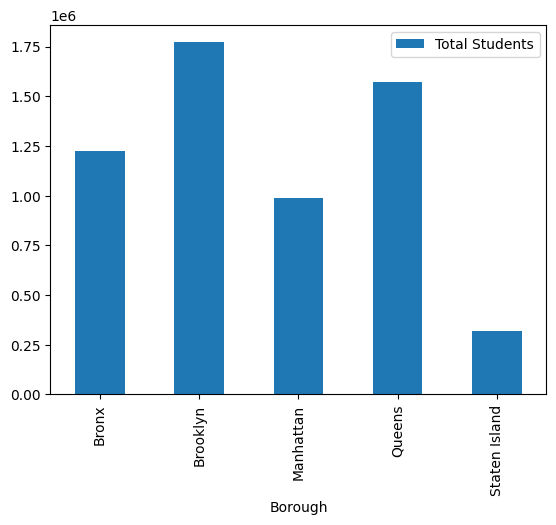

In [3]:
ax = table.plot.bar(x="Borough", y=["Total Students"])

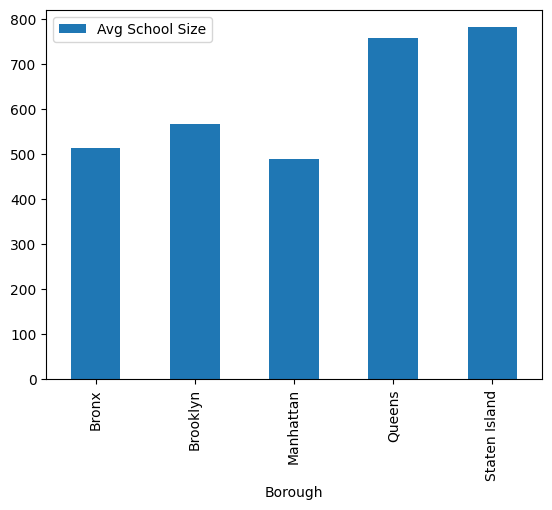

In [4]:
# doe the same thing with average school size
ax = table.plot.bar(x="Borough", y=["Avg School Size"])

Labels, figure size, and more
------------------------------------------
We can make a pretty decent bar chart for a single line of code, but with a few more arguments to our function, we can make it even better. To do this, we're going to use a few more features from `matplotlib` and related libraries.

In this example we will specify:

- sorting the columns by size
- setting the images size
- adding titles and labels
- changing colors

You may have noticed that we were assigning the **return** value from `plot()` into a new variable called `ax`. This servers the simple purpose of showing only the chart (and not the return value), but it also allows us to keep adding items to our chart. 

In [5]:
# before drawing anything, change the "style"
plt.style.use('dark_background')

# show all the styles
# change dark_background to any style from this list to try it out
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

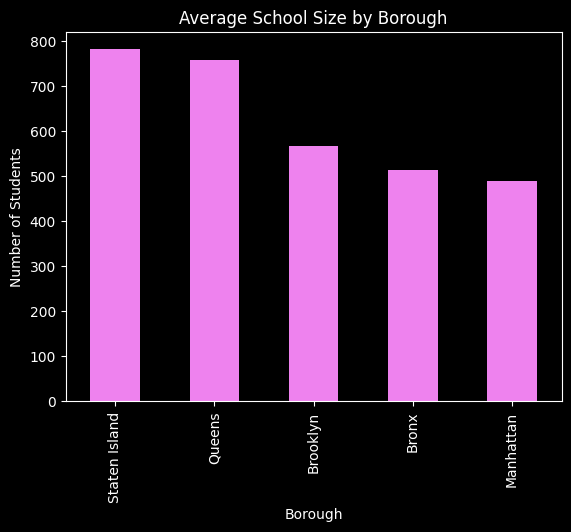

In [6]:
# sort the tabgle in descending order by school size -- this will order our bars
table = table.sort_values(by="Avg School Size", ascending=False)

ax = table.plot.bar(x="Borough", y=["Avg School Size"], color="violet")
ax.set_title("Average School Size by Borough")
ax.set_ylabel("Number of Students")
ax.get_legend().remove()

Grouped Bar Chart: Citywide student demographics
------------------------------------------------------------------------
Drawing from the counts of students in different
demographic categories (`asian_n`, `ell_n`) we will draw a basic bar chart.

### `melt()` to un-pivot data
The first thing we do is **melt** the columns with the demographic counts
into a single column. Typically, a melt will create two new columns:
one with the categories or `id` labels for the row, and a second with
the `values` for the row. In this example we create **enroll_cat** (`id`)
to tell us which _category_ of enrollment number we're looking at
and **enrollment** (`values`) to hold the number of students for that row for
that category. Each row in this dataframe reports the observation
for a specicif school, grade, academic year (`dbn`, `grade`, `year`).


In [7]:
tests = exams.load_math_ela_wide()
tests


,dbn,grade,category_math,number_tested_math,mean_scale_score_math,level_1_n_math,level_1_pct_math,level_2_n_math,level_2_pct_math,level_3_n_math,...,level_2_pct_ela,level_3_n_ela,level_3_pct_ela,level_4_n_ela,level_4_pct_ela,level_3_4_n_ela,level_3_4_pct_ela,test_year_ela,charter_ela,school_name_ela
0,01M015,3,All Students,27,277.777771,16.0,0.592593,11.0,0.407407,0.0,...,0.407407,2.0,0.074074,0.0,0.000,2.0,0.074074,2013,0,NaN
1,01M015,3,All Students,27,277.777771,16.0,0.592593,11.0,0.407407,0.0,...,0.421053,0.0,0.000000,0.0,0.000,0.0,0.000000,2013,0,NaN
2,01M015,3,All Students,27,277.777771,16.0,0.592593,11.0,0.407407,0.0,...,0.375000,2.0,0.250000,0.0,0.000,2.0,0.250000,2013,0,NaN
3,01M015,3,All Students,27,277.777771,16.0,0.592593,11.0,0.407407,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,0,NaN
4,01M015,3,All Students,27,277.777771,16.0,0.592593,11.0,0.407407,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5516426,84X730,3,All Students,51,604.000000,7.0,0.137000,12.0,0.235000,20.0,...,0.431000,23.0,0.451000,4.0,0.078,27.0,0.529000,2019,1,BRONX CHARTER SCHOOL FOR THE ARTS
5516427,84X730,4,All Students,47,597.000000,15.0,0.319000,10.0,0.213000,15.0,...,0.286000,13.0,0.265000,4.0,0.082,17.0,0.347000,2019,1,BRONX CHARTER SCHOOL FOR THE ARTS
5516428,84X730,5,All Students,53,593.000000,23.0,0.434000,13.0,0.245000,12.0,...,0.377000,8.0,0.151000,7.0,0.132,15.0,0.283000,2019,1,BRONX CHARTER SCHOOL FOR THE ARTS
5516429,84X730,6,All Students,110,595.000000,38.0,0.345000,30.0,0.273000,34.0,...,0.292000,23.0,0.204000,12.0,0.106,35.0,0.310000,2019,1,BRONX CHARTER SCHOOL FOR THE ARTS


In [8]:

# work with just one year to make things clearer
totals = totals[totals["ay"] == 2020]


# define the category columns -- the columns which will be "melted" / collapsed
cats = ["total_enrollment", "asian_n", "black_n","hispanic_n","white_n"]

# the columns that will be the same after the melt
id_cols = ["dbn", "district", "boro"]

# get just the cols we want from the df
totals = totals[id_cols + cats]

# make nice names for our columns by dropping the _n and renaming total_enrollment to "all students"
# these column headers will become the data in the enroll_cat column after the melt
cats = ["all students", "asian", "black", "hispanic","white"]
totals.columns = id_cols + cats

totals

NameError: name 'totals' is not defined

In [ ]:
# melt tutorial:
# https://www.educba.com/pandas-melt/
data = pd.melt(totals, id_vars=id_cols, value_vars=cats, var_name="enroll_cat", value_name="enrollment")


# let's look at one grade for one school for one year (2019) to see what ouplt.style.use('fivethirtyeight')r data looks like
data.query("dbn == '01M015'")

,dbn,district,boro,enroll_cat,enrollment
0,01M015,1,Manhattan,all students,193
1878,01M015,1,Manhattan,asian,26
3756,01M015,1,Manhattan,black,53
5634,01M015,1,Manhattan,hispanic,102
7512,01M015,1,Manhattan,white,11


In [ ]:
# use groupby and agg to get the city wide enrollment data
city_enroll = data[["enroll_cat", "enrollment"]].groupby("enroll_cat", as_index=False).agg(sum)

city_enroll

,enroll_cat,enrollment
0,all students,1050017
1,asian,173758
2,black,261595
3,hispanic,432188
4,white,151060


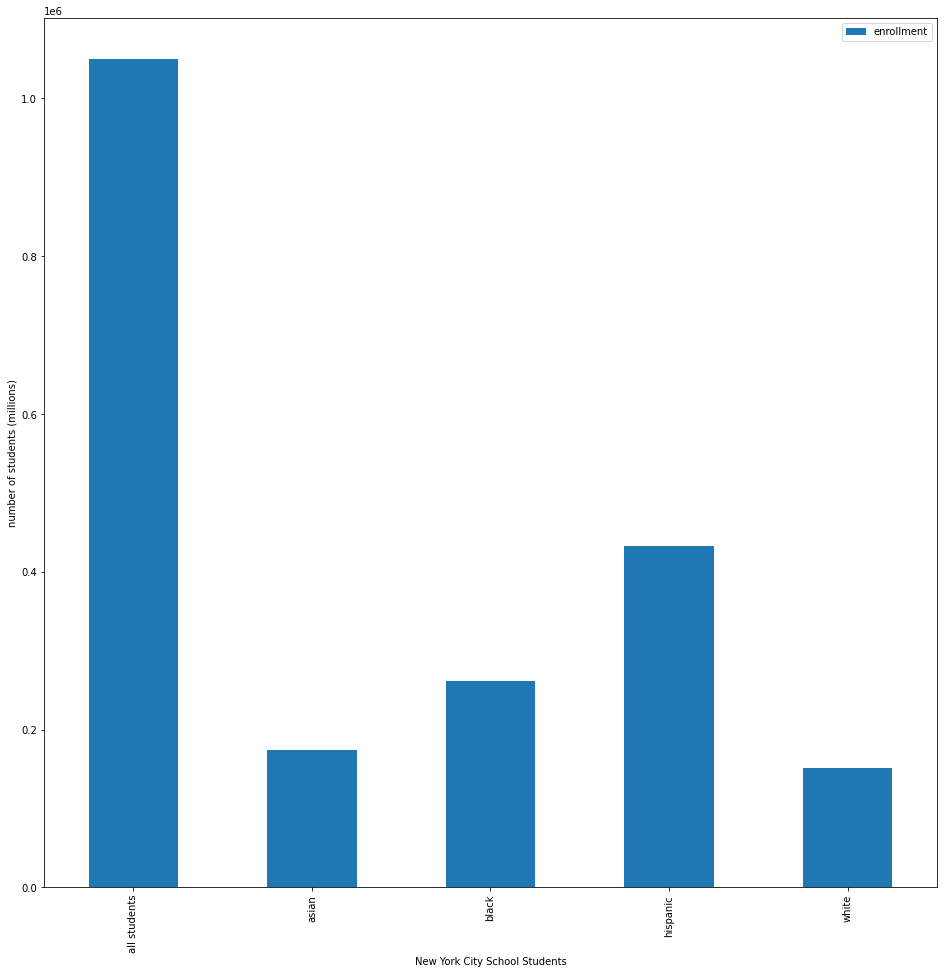

In [ ]:
# create a bar chart of new york city student population
# the size is set in inches (don't think it's pixels or else it takes a long time to run)
# to see the full size image, right click and view image

ax = city_enroll.plot(x="enroll_cat", y=["enrollment"], kind="bar", figsize=(16, 16))

ax.set_xlabel("New York City School Students")

# Set the y-axis label
ax.set_ylabel("number of students (millions)")
pass # pass so only the chartdisplays with no other output

Grouped Bar Chart: student demographics by district
-----------------------------------------------------------------------------
Now we'll make a more complicated bar chart, where we display the
ethnic group populations at the district leve. For this chart
we will have 20 bars (4 groups x 5 boroughs). We use more of the
functions in `matplot` to style our ouput, add titls and legends, etc.

Links:

- [Python Charts: Grouped Bar Charts with Labels in Matplotlib ](https://www.pythoncharts.com/matplotlib/grouped-bar-charts-matplotlib/)
- [Matplotlib: Legend Demo](https://matplotlib.org/stable/gallery/text_labels_and_annotations/legend_demo.html)
- [Seaborn: set_context()](https://seaborn.pydata.org/generated/seaborn.set_context.html)

In [ ]:
# now group them by district
boro_enroll = data[["boro", "enroll_cat", "enrollment"]].groupby(["boro", "enroll_cat"], as_index=False).agg(sum)
ui.fmt_table(boro_enroll, num_cols=["enrollment"], col_map={"enroll_cat":"student group"})


,boro,student group,enrollment
0,Bronx,all students,"218,081"
1,Bronx,asian,"11,006"
2,Bronx,black,"58,362"
3,Bronx,hispanic,"136,098"
4,Bronx,white,"8,934"
5,Brooklyn,all students,"315,797"
6,Brooklyn,asian,"53,857"
7,Brooklyn,black,"108,445"
8,Brooklyn,hispanic,"90,867"
9,Brooklyn,white,"54,185"


In [ ]:
# create a df for each group we want to plot
asian = boro_enroll.query("enroll_cat == 'asian'")
black = boro_enroll.query("enroll_cat == 'black'")
hispanic = boro_enroll.query("enroll_cat == 'hispanic'")
white = boro_enroll.query("enroll_cat == 'white'")

# get the tick marks for the x access
x = np.arange(len(df.boro.unique()))

# instead of plotting the dataframe, get the figure and axis components from the plot
fig, ax = plt.subplots(figsize=(16, 9))

# the bar width in inches
w = .17

# add the bars
ax.bar(x + w, hispanic["enrollment"], width=w, label="Hispanic")
ax.bar(x + w * 2, black["enrollment"], width=w, label="Black")
ax.bar(x + w * 3, white["enrollment"], width=w, label="White")
ax.bar(x + w * 4, asian["enrollment"], width=w, label="Asian")

# set the x-ticks to the middle of the bar groups and add labels
ax.set_xticks(x + (w * 5) / 2)
ax.set_xticklabels(boro_enroll.boro.unique())


# style the output
sns.set_context('talk')
# sns.set_context('poster')
# sns.set_context('paper')
# sns.set_context('notebook')

# Set the y-axis label
ax.set_ylabel("Number of students", labelpad=15)

# Axis styling.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#efefef')
ax.xaxis.grid(False)


ax.legend()
fig.tight_layout()
ax.set_title('New York City School Enrollment by Borough', pad=40)

pass

NameError: name 'boro_enroll' is not defined